Creating a new dataset based upon the wind_comparison dataset.
Plots from the dataset show there is a difference between the winds between the 
ideal dataset (nc) and the interp forcings dataset. It is therefore a need to rotate the winds.
Plots from previous notebook showing the differences in winds are under malene/ocean-ai/plot/figures.
New notebook because the files used in the previous notebook are removed and the dates are changed.

goal:
Rotate winds in the interp forcings files and make sure they then are the same as the "fasit" dataset, ie. the hindcast nc files. 

In [7]:
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib as mpl
import numpy as np
import scipy as sp

In [12]:
#based on the 1th of May 2023

ideal_file_path = f'/lustre/storeB/project/fou/hi/roms_hindcast/norkyst_v3/sdepth'
interp_file_path = f'/lustre/storeB/project/fou/hi/foccus/datasets/norkystv3_hindcast_atm_forcing/interpolated'

ds_ideal_2023 = xr.open_dataset(f'{ideal_file_path}/2023/05/norkyst800-20230501.nc').isel(time = 0)
interp_2023_u = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Uwind.nc').isel(time=0)
interp_2023_v = xr.open_dataset(f'{interp_file_path}/arome_meps_2_5km_2023050100-2024010100_ext_newTair_NK800_Vwind.nc').isel(time=0)

In [13]:
#select out u and v winds from the ideal dataset (fasit)
ds_ideal_u_2023 = ds_ideal_2023["Uwind_eastward"]
ds_ideal_v_2023 = ds_ideal_2023["Vwind_northward"]

In [66]:
#then we have to rotate the winds for the interp forcings files
def rotate_vectorfield(U,V,alpha):
    '''rotate wind vectors clockwise. alpha may be a scalar or an array
    alpha is in degrees
    returns u,v '''
    alpha = np.array(alpha)*np.pi/180
    alpha = alpha.flatten()
    R = np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)] ])
    shpe = U.shape
    origwind = np.array((U.flatten(), V.flatten()))
    if len(R.shape)==2:
        rotwind = dot(R, origwind) # for constant rotation angle
    else:
        # for rotation angle given as array with same dimensions as U and V:
        # k-loop with rotwind(k) = dot(R(i,j,k), origwind(j,k)) (einstein summation indices)
        rotwind = np.einsum("ijk,ik -> jk", R, origwind)  # einstein summation indices
    Urot, Vrot = rotwind[0,:], rotwind[1,:]
    Urot = Urot.reshape(shpe)
    Vrot = Vrot.reshape(shpe)
    return Urot, Vrot

In [67]:
urot, vrot = rotate_vectorfield(interp_2023_u["Uwind"].values, interp_2023_v["Vwind"].values, interp_2023_u["lat"].values)

In [68]:
urot

array([[ -1.131288  ,  -1.10524121,  -1.0766937 , ...,   2.73381579,
          2.75434168,   2.7741827 ],
       [ -1.08870568,  -1.06451003,  -1.04033569, ...,   2.71394275,
          2.73364317,   2.75210731],
       [ -1.04575076,  -1.02003275,  -0.99433681, ...,   2.70213092,
          2.71376315,   2.74145251],
       ...,
       [  3.35361535,   3.27951186,   3.20536104, ..., -13.33944796,
        -13.32419937, -13.32096188],
       [  3.30572382,   3.23159445,   3.15743432, ..., -13.35937088,
        -13.34410804, -13.32886521],
       [  3.25783938,   3.18368342,   3.10949668, ..., -13.37929525,
        -13.36403137, -13.34878396]], shape=(1148, 2747))

In [69]:
vrot

array([[ 2.30787882,  2.22792771,  2.14096167, ...,  9.25473093,
         9.20591919,  9.17279679],
       [ 2.23347389,  2.15863485,  2.08379772, ...,  9.27007528,
         9.21431886,  9.16408371],
       [ 2.15960592,  2.08686657,  2.01412713, ...,  9.2780046 ,
         9.22967527,  9.15966964],
       ...,
       [-0.28128491, -0.41765431, -0.55403329, ...,  6.91567269,
         6.92488681,  6.92762402],
       [-0.36931021, -0.5056915 , -0.64205194, ...,  6.90571993,
         6.91494315,  6.92415131],
       [-0.45730865, -0.59370316, -0.73007682, ...,  6.8957702 ,
         6.90499541,  6.91420746]], shape=(1148, 2747))

Text(0.5, 1.0, 'After rotation')

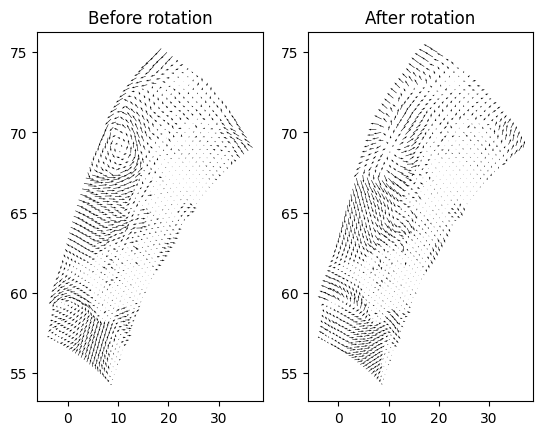

In [70]:
s  = 50
fig, ax = plt.subplots(1,2)
ax[0].quiver(interp_2023_u["lon"].values[::s,::s], interp_2023_u["lat"].values[::s,::s], interp_2023_u["Uwind"].values[::s,::s], interp_2023_v["Vwind"].values[::s,::s])
ax[1].quiver(interp_2023_u["lon"].values[::s,::s], interp_2023_u["lat"].values[::s,::s],urot[::s,::s], vrot[::s,::s])
ax[0].set_title("Before rotation")
ax[1].set_title("After rotation")

Text(0.5, 1.0, 'After rotation')

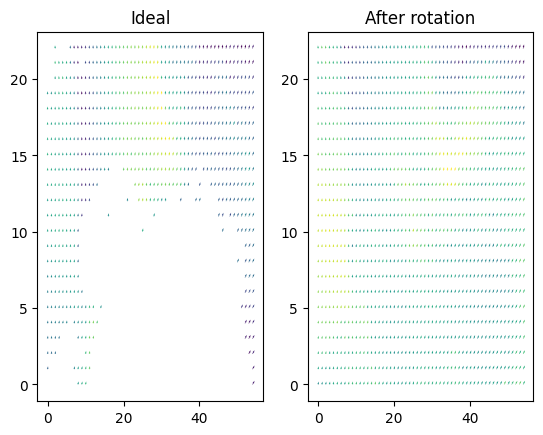

In [71]:
s  = 50
fig, ax = plt.subplots(1,2)
ax[0].quiver(ds_ideal_u_2023["lon"].values[::s,::s], ds_ideal_u_2023["lat"].values[::s,::s], ds_ideal_u_2023.values[::s,::s])
ax[1].quiver(interp_2023_u["lon"].values[::s,::s], interp_2023_u["lat"].values[::s,::s],urot[::s,::s])
ax[0].set_title("Ideal")
ax[1].set_title("After rotation")


In [72]:
def plotting_output_compare(variable_1, variable_2, title_1, title_2, title_3, variable_1_name, variable_2_name, suptitle):
    fig,ax = plt.subplots(3, figsize = (8,14))

    #Colormap colors
    cmap = plt.cm.coolwarm
    norm1 = mpl.colors.Normalize(vmin=-15,vmax=20) 
    norm2 = mpl.colors.Normalize(vmin=-1,vmax=1) #small values in the last plot to be able to easily spot the difference when comparing plots 

    #Image 1
    image1 = ax[0].pcolormesh(variable_1, shading = "auto", cmap=cmap, norm = norm1)
    ax[0].set_title(title_1)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    #Image 2
    image2 = ax[1].pcolormesh(variable_2, shading = "auto", cmap = cmap, norm = norm1)
    ax[1].set_title(title_2)
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("y")

    #Image 3 - comparing the data. Value 2 - value 1. 
    image3 = ax[2].contourf(variable_2 - variable_1, shading = "auto", cmap = cmap, norm = norm2)
    #image3 = ax[2].quiver(x,y,variable_2 - variable_1, scale=1, color = "black")
    ax[2].set_title(title_3)
    ax[2].set_xlabel("x")
    ax[2].set_ylabel("y")
    plt.suptitle(suptitle)
    plt.tight_layout()

    
    fig.colorbar(image1, cmap=cmap, ax=ax[0], label = f'{variable_1_name}')
    fig.colorbar(image2, cmap=cmap, ax=ax[1], label = f'{variable_2_name}')
    fig.colorbar(image3, cmap=cmap, ax=ax[2], label = f'Comparison of: {variable_2_name} - {variable_1_name}')
    return plotting_output_compare

/tmp/ipykernel_710028/2567467154.py:22: UserWarning: The following kwargs were not used by contour: 'shading'
  image3 = ax[2].contourf(variable_2 - variable_1, shading = "auto", cmap = cmap, norm = norm2)


<function __main__.plotting_output_compare(variable_1, variable_2, title_1, title_2, title_3, variable_1_name, variable_2_name, suptitle)>

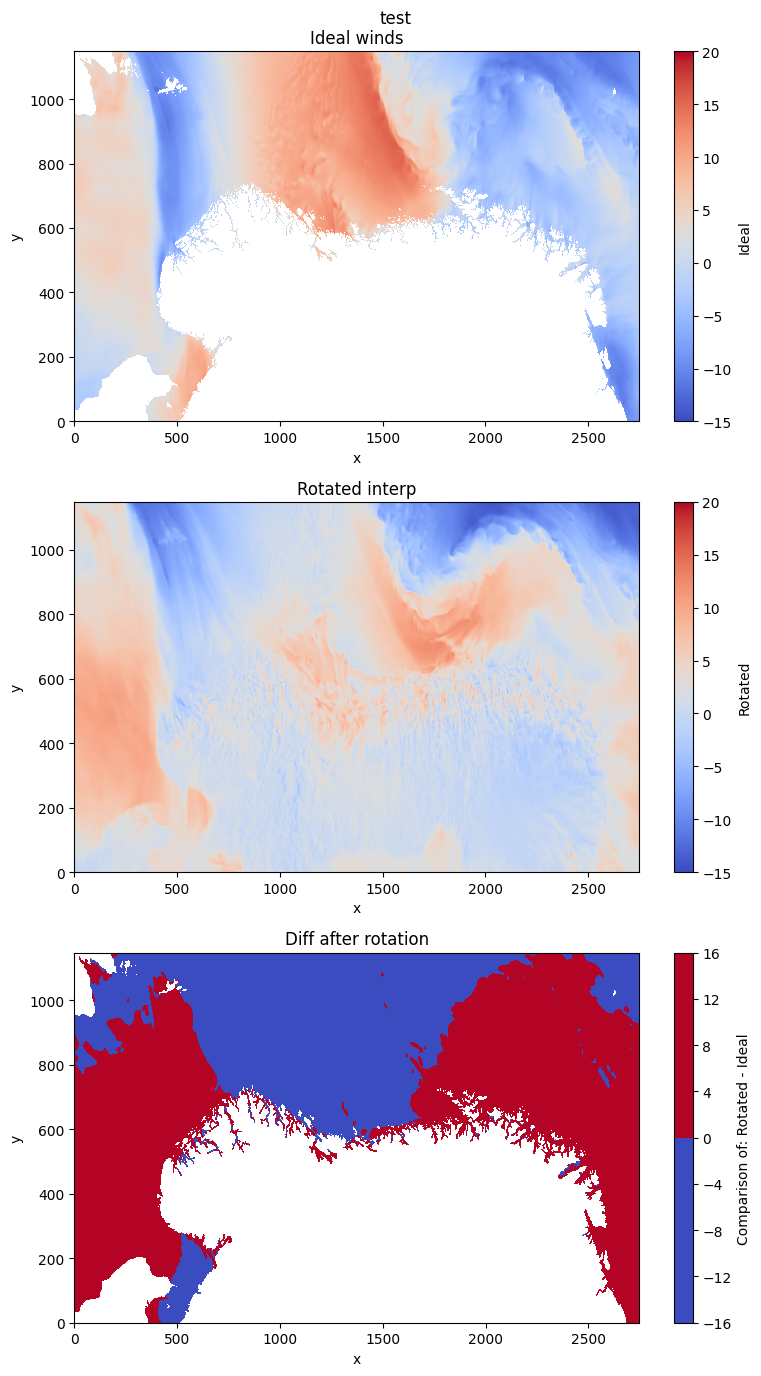

In [73]:
plotting_output_compare(variable_1=ds_ideal_u_2023, variable_2=urot, title_1="Ideal winds", title_2="Rotated interp", title_3="Diff after rotation", suptitle="test", variable_1_name="Ideal", variable_2_name="Rotated")

/tmp/ipykernel_710028/2567467154.py:22: UserWarning: The following kwargs were not used by contour: 'shading'
  image3 = ax[2].contourf(variable_2 - variable_1, shading = "auto", cmap = cmap, norm = norm2)


<function __main__.plotting_output_compare(variable_1, variable_2, title_1, title_2, title_3, variable_1_name, variable_2_name, suptitle)>

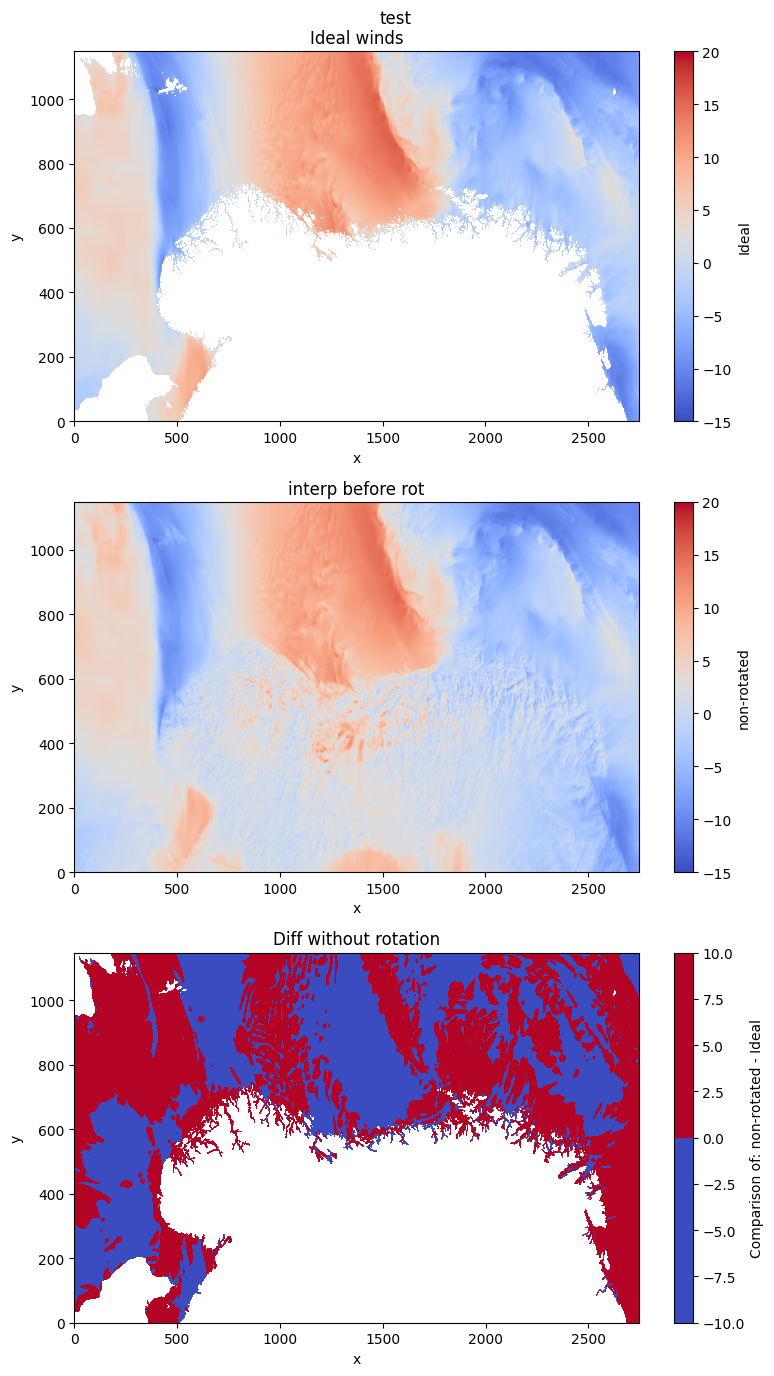

In [74]:

plotting_output_compare(variable_1=ds_ideal_u_2023, variable_2=interp_2023_u["Uwind"], title_1="Ideal winds", title_2="interp before rot", title_3="Diff without rotation", suptitle="test", variable_1_name="Ideal", variable_2_name="non-rotated")

In [75]:
diff = ds_ideal_u_2023.values - interp_2023_u["Uwind"].values
np.printoptions(np.inf)
print(diff)

[[        nan         nan         nan ... -0.23543937 -0.20795071
  -0.22554809]
 [        nan         nan         nan ... -0.21340899 -0.24212279
  -0.2252354 ]
 [        nan         nan         nan ... -0.23117195 -0.24008267
  -0.26495243]
 ...
 [        nan         nan         nan ...  1.51530182  1.52930522
   1.55000019]
 [        nan         nan         nan ...  1.5096565   1.52366387
   1.54766648]
 [        nan         nan         nan ...  1.50401135  1.51801904
   1.54202295]]


In [76]:
diff2 = ds_ideal_u_2023.values - urot

In [77]:
print(diff2)

[[         nan          nan          nan ... -10.65381539 -10.59434135
  -10.5941824 ]
 [         nan          nan          nan ... -10.63394235 -10.62364304
  -10.57210701]
 [         nan          nan          nan ... -10.65213073 -10.623763
  -10.60145216]
 ...
 [         nan          nan          nan ...   4.85944842   4.8541991
    4.87096207]
 [         nan          nan          nan ...   4.87937134   4.87410777
    4.8788654 ]
 [         nan          nan          nan ...   4.89929571   4.8940311
    4.89878415]]


In [78]:
#make sure it uses the same times
ds_ideal_u_2023.time.values

np.datetime64('2023-05-01T00:00:00.000000000')

In [79]:
interp_2023_u.time.values

np.datetime64('2023-05-01T00:00:00.000000000')

/tmp/ipykernel_710028/2567467154.py:22: UserWarning: The following kwargs were not used by contour: 'shading'
  image3 = ax[2].contourf(variable_2 - variable_1, shading = "auto", cmap = cmap, norm = norm2)


<function __main__.plotting_output_compare(variable_1, variable_2, title_1, title_2, title_3, variable_1_name, variable_2_name, suptitle)>

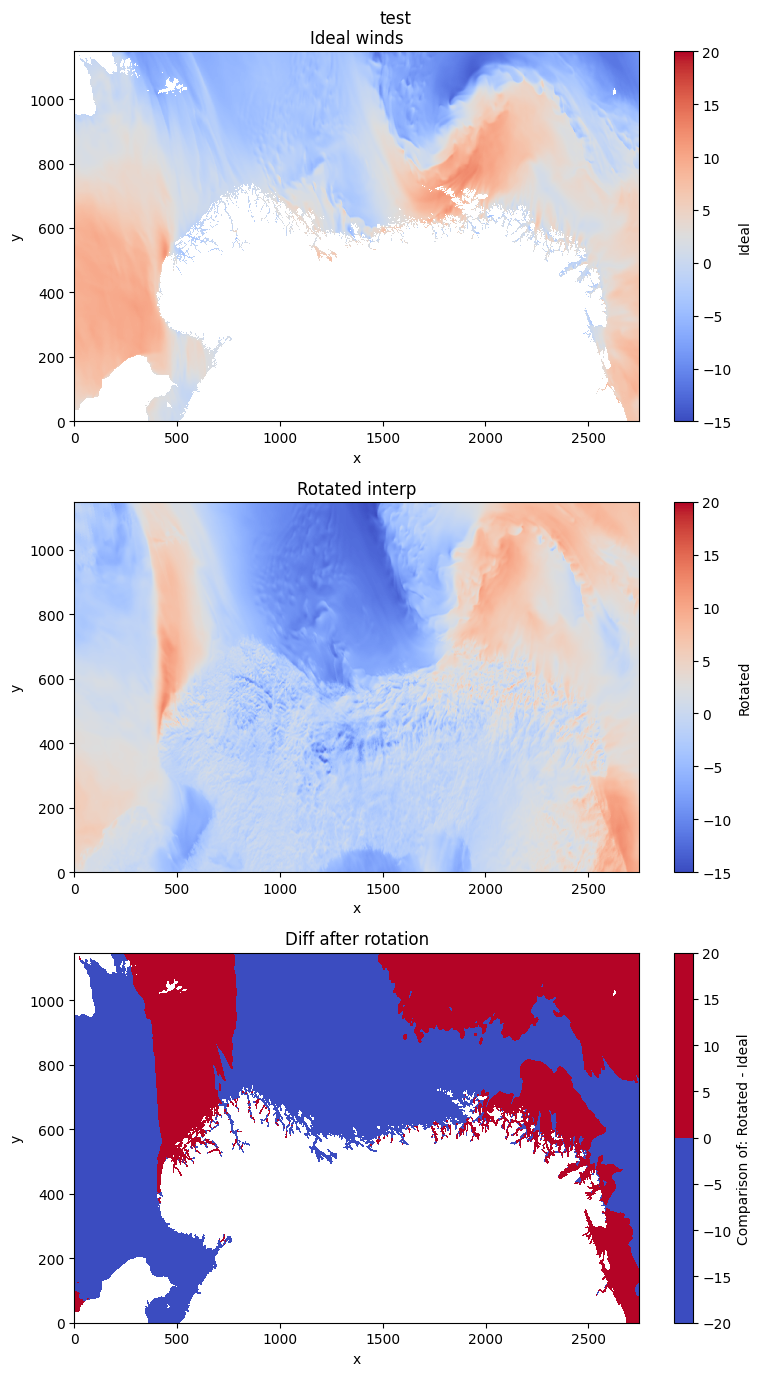

In [80]:
plotting_output_compare(variable_1=ds_ideal_v_2023, variable_2=vrot, title_1="Ideal winds", title_2="Rotated interp", title_3="Diff after rotation", suptitle="test", variable_1_name="Ideal", variable_2_name="Rotated")
